In [63]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [64]:
def initialize_birds(N_birds, L, restricted_area=None):
    '''
    Set initial positions, direction, and velocities, avoiding restricted areas if 
    there are any
    '''
    x = np.zeros((N_birds, 1))
    y = np.zeros((N_birds, 1))

    for bird in range(N_birds):
        while True:
            x_temp = np.random.rand() * L
            y_temp = np.random.rand() * L
            
            if restricted_area:
                x_min, x_max, y_min, y_max = restricted_area
                if x_min <= x_temp <= x_max and y_min <= y_temp <= y_max:
                    continue  
            
            x[bird] = x_temp
            y[bird] = y_temp
            break
    
    # restricted area centre
    rx = (x_max + x_min) / 2
    ry = (y_max + y_min) / 2
    
    # bird velocities
    theta = 2 * np.pi * np.random.rand(N_birds,1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, rx, ry

In [65]:
def initialize_drones(drone_x, drone_y):
    
    N_drones = len(drone_x)
    
    drone_x = drone_x*np.ones((N_drones,1), dtype=np.float64)
    drone_y = drone_y*np.ones((N_drones,1), dtype=np.float64)
    
    drone_vx = np.zeros((N_drones,1), dtype=np.float64)  
    drone_vy = np.zeros((N_drones,1), dtype=np.float64)

    return N_drones, drone_x, drone_y, drone_vx,drone_vy

In [66]:
def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

In [67]:
def update_positions(x, y, vx, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

In [68]:
def get_centering_velocities(x, y, N_birds, Rsq, lambda_c):
    '''
    Compute the velocity towards the centre of mass of local birds in a
    radius R for each bird
    '''
    vcx = np.zeros((N_birds,1))
    vcy = np.zeros((N_birds,1)) 

    for bird in range(N_birds):
        neighbours = (x - x[bird])**2 + (y - y[bird])**2 < Rsq
        neighbours[bird] = False
        neighbour_count = np.sum(neighbours)
        
        if neighbour_count > 0:
            x_center = np.sum(x[neighbours]) / neighbour_count
            y_center = np.sum(y[neighbours]) / neighbour_count

            vcx[bird] = lambda_c * (x_center - x[bird])
            vcy[bird] = lambda_c * (y_center - y[bird])

    return vcx, vcy

In [69]:
def get_avoiding_velocities(x, y, N_birds, r, lambda_av):
    '''
    Compute the velocity away from potential collsions for each bird with
    avoidance radius r
    '''
    vavx = np.zeros((N_birds,1))
    vavy = np.zeros((N_birds,1))
    
    for bird in range(N_birds):
        too_close = (x-x[bird])**2 + (y-y[bird])**2 < r**2
        vavx[bird] = lambda_av * np.sum(x[bird] - x[too_close])
        vavy[bird] = lambda_av * np.sum(x[bird] - x[too_close])
        
    return vavx, vavy

In [70]:
def get_matching_velocities(x, y, vx, vy, N_birds, Rsq, lambda_m):
    '''
    Compute the average velocity of local birds in a radius R and align with 
    it for each bird
    '''
    vmx = np.zeros((N_birds,1))
    vmy = np.zeros((N_birds,1))
    
    for bird in range(N_birds):
        neighbours = (x-x[bird])**2+(y-y[bird])**2 < Rsq
        avg_vx = np.sum(vx[neighbours]) / len(neighbours)
        avg_vy = np.sum(vy[neighbours]) / len(neighbours)
        vmx[bird] = lambda_m * (avg_vx - vx[bird])
        vmy[bird] = lambda_m * (avg_vy - vy[bird])
        
    return vmx, vmy

In [71]:
def get_attractive_velocities(x, y, vx, vy, rx, ry, N_birds, lambda_at):
    '''
    Compute the velocity of birds towards the centre of the restricted area
    '''
    vatx = np.zeros((N_birds,1))
    vaty = np.zeros((N_birds,1))

    for bird in range(N_birds):
        dx = rx - x[bird]
        dy = ry - y[bird]
        dist_sq = dx**2 + dy**2

        if dist_sq < attract_r**2 and dist_sq > 0:
            vatx[bird] = lambda_at * dx / np.sqrt(dist_sq)
            vaty[bird] = lambda_at * dy / np.sqrt(dist_sq)
        
    return vatx, vaty

In [72]:
def get_repulsive_velocities(x, y, drone_x, drone_y, N_birds, N_drones, drone_r, lambda_r):
    '''
    Compute the velocity away from drones for each bird with repulsive radius 
    drone_r
    '''
    vrx = np.zeros((N_birds,1))
    vry = np.zeros((N_birds,1))

    for bird in range(N_birds):
        for drone in range(N_drones):
            dx = x[bird] - drone_x[drone]
            dy = y[bird] - drone_y[drone]
            dist_sq = dx**2 + dy**2

            if dist_sq < drone_r**2 and dist_sq > 0:
                vrx[bird] += lambda_r * dx / dist_sq
                vry[bird] += lambda_r * dy / dist_sq

    return vrx, vry

In [73]:
def update_velocities(x, y, vx, vy, rx, ry, drone_x, drone_y, Rsq, eta, N_birds, N_drones):
    '''
    Update the velocities for the next time step using the centering, avoiding 
    and matching components 
    '''
    vcx, vcy = get_centering_velocities(x, y, N_birds, Rsq, lambda_c)
    vavx, vavy = get_avoiding_velocities(x, y, N_birds, r, lambda_av)
    vmx, vmy = get_matching_velocities(x, y, vx, vy, N_birds, Rsq, lambda_m)
    vatx, vaty = get_attractive_velocities(x, y, vx, vy, rx, ry, N_birds, lambda_at)
    vrx, vry = get_repulsive_velocities(x, y, drone_x, drone_y, N_birds, N_drones, drone_r, lambda_r)
    
    vx += vcx + vavx + vmx + vatx + vrx + eta*(np.random.rand(N_birds,1)-0.5)
    vy += vcy + vavy + vmy + vaty + vry + eta*(np.random.rand(N_birds,1)-0.5)
    
    v_norms = np.sqrt(vx**2 + vy**2)

    normalised_vx = np.minimum(1, v_max / v_norms) * vx
    normalised_vy = np.minimum(1, v_max / v_norms) * vy

    return normalised_vx, normalised_vy

In [74]:
def updateDroneVelocity(x, y, drone_vx, drone_vy, N_birds, Rsq, lambda_c, drone_x, drone_y, drone_v_max, x_min=8, x_max=12, y_min=8, y_max=12):
    '''
    Update drone velocities according to 'sheepdog' model
    '''
    N_drones=len(drone_x)
    centringAttractionX, centringAttractionY = get_centering_velocities_for_drones(x, y, drone_x, drone_y, N_birds, N_drones, Rsq, lambda_c, x_min=8, x_max=12, y_min=8, y_max=12)
    
    
    # Update drone velocities
    drone_vx += centringAttractionX
    drone_vy += centringAttractionY

    
    v_norms = np.sqrt(drone_vx**2 + drone_vy**2) if np.sqrt(drone_vx**2 + drone_vy**2) != 0 else 1
    normalised_drone_vx = np.minimum(1, drone_v_max / v_norms) * drone_vx
    normalised_drone_vy = np.minimum(1, drone_v_max / v_norms) * drone_vy
    
    return normalised_drone_vx, normalised_drone_vy


In [75]:
def updateDronePosition(drone_x, drone_y, drone_vx, drone_vy, dt, x_min=8, x_max=12, y_min=8, y_max=12, L=20):
    '''
    Update drone positions with boundary conditions in restricted area.
    '''

    new_x = drone_x + drone_vx * dt
    # Update x position with boundary conditions
    drone_x = new_x

    new_y = drone_y + drone_vy * dt
    drone_y = new_y

    # Apply periodic boundary conditions for movement outside the overall simulation box
    drone_x, drone_y = apply_boundary_conditions(drone_x, drone_y, L)

    return drone_x, drone_y


In [ ]:
def get_centering_velocities_for_drones(x, y, drone_x, drone_y, N_birds, N_drones, Rsq, lambda_c, x_min=8, x_max=12, y_min=8, y_max=12):
    '''
    Calculate centering velocity for drones towards the center of the birds
    within specified bounds for x and y.
    '''
    drone_vx = np.zeros((N_drones, 1))
    drone_vy = np.zeros((N_drones, 1))

    # Filter birds within the specified bounds
    in_bounds = ((x >= x_min) & (x <= x_max)) & ((y >= y_min) & (y <= y_max))

    for drone in range(N_drones):
        # Select birds within bounds
        birds_nearby = in_bounds 
        
        # If there are birds meeting the criteria, compute centering velocities
        if np.any(birds_nearby):
            dx = np.mean(x[birds_nearby] - drone_x[drone])  # mean of differences in x
            dy = np.mean(y[birds_nearby] - drone_y[drone])  # mean of differences in y
            
            # Update drone velocities towards the birds
            drone_vx[drone] += lambda_c * dx  
            drone_vy[drone] += lambda_c * dy 

        else:
            dx = drone_x[drone] - (x_max +x_min) / 2
            dy = drone_y[drone] - (y_max +y_min) / 2

            if dist_sq > 0:
                drone_vx[drone] = -dx / np.abs(dx)
                drone_vy[drone] = -dy / np.abs(dy)

    return drone_vx, drone_vy


In [77]:
def step(x, y, vx, vy, rx, ry, drone_x, drone_y, Rsq, eta, N_birds, N_drones, dt, drone_vx, drone_vy, drone_v_max):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x,y = update_positions(x, y, vx, vy, dt, L)
    vx,vy = update_velocities(x, y, vx, vy, rx, ry, drone_x, drone_y, Rsq, eta, N_birds, N_drones)


    # Update drone positions
    drone_x, drone_y = updateDronePosition(drone_x, drone_y, drone_vx, drone_vy, dt, L)
    
    # Compute centering and repulsion for drones
    drone_vx, drone_vy = updateDroneVelocity(x, y, drone_vx, drone_vy, N_birds, Rsq, lambda_c, drone_x, drone_y,drone_v_max)
    
    return x, y, vx, vy, drone_x, drone_y, drone_vx, drone_vy

In [78]:
def update_quiver(q_birds, q_drones, x, y, vx, vy, drone_x, drone_y):
    '''
    Update quivers for both birds and drones with new position and velocity information
    This is only used for plotting
    '''
    # Update bird quiver
    q_birds.set_offsets(np.column_stack([x, y]))  # Set the new bird positions
    q_birds.set_UVC(vx, vy)  # Set the bird velocities
    
    # Update drone quiver
    q_drones.set_offsets(np.column_stack([drone_x, drone_y]))  # Set the new drone positions
    
    return q_birds, q_drones

In [83]:
# Simulation parameters

v0           = 1.0      # velocity
v_max        = 1.5      # max velocity
drone_v_max  = 1.5
lambda_c     = 0.075    # centring strength
lambda_av    = 0.1      # avoiding strength
lambda_m     = 0.1      # matching strength
lambda_at    = 0.0     # attraction strength
lambda_r     = 0.5      # repulsion strength
eta          = 0.5      # random fluctuation in angle (in radians)
L            = 20       # size of box
R            = 1        # interaction radius
Rsq          = R**2     # square of the interaction radius
r            = 0.2      # separation distance
dt           = 0.1      # time step
Nt           = 300      # number of time steps
N_birds      = 300     # number of birds
drone_r      = 2.0      # repulsion radius
attract_r    = 5.0      # attraction radius to farm 

restricted_area = (8, 12, 8, 12)



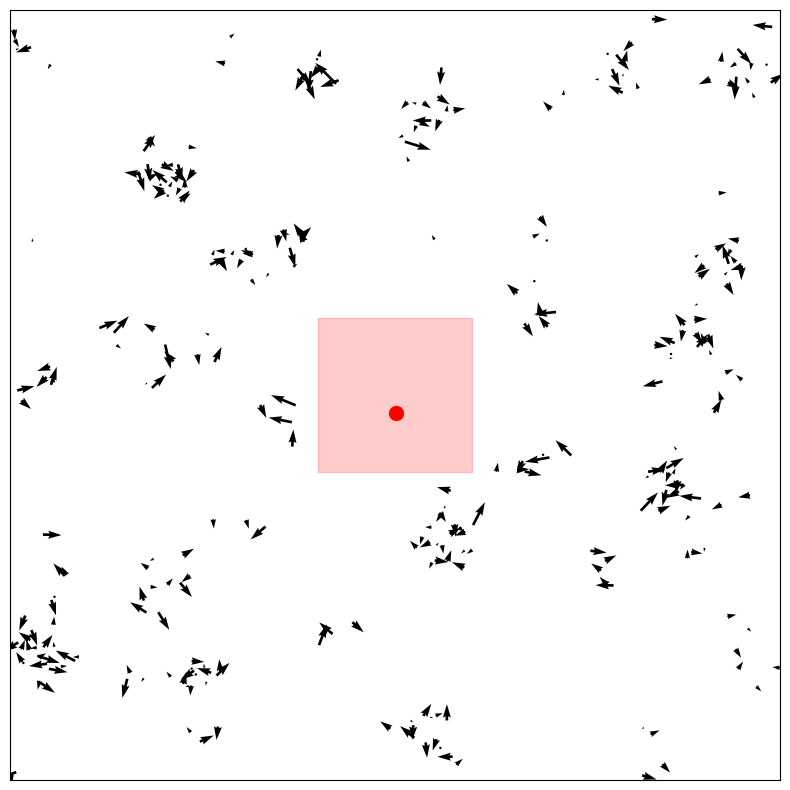

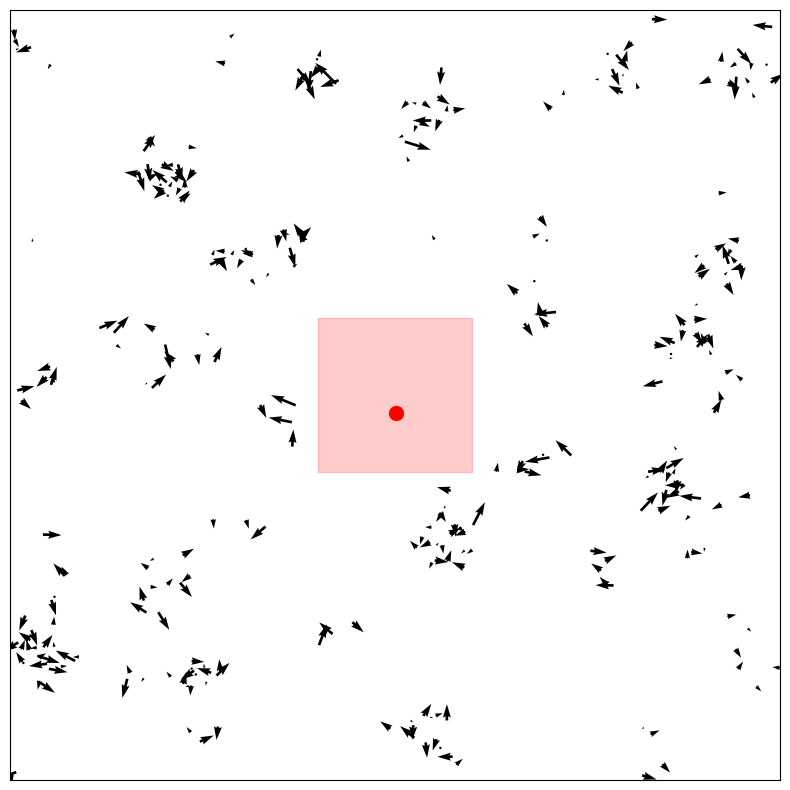

In [85]:
np.random.seed(13)      # set the random number generator seed

# set up a figure
fig, ax = plt.subplots(figsize = (10, 10))

# get the initial configuration
x, y, vx, vy, rx, ry = initialize_birds(N_birds, L, restricted_area)

# set drone locations
drone_x = np.array([10],dtype=np.float64)
drone_y = np.array([10],dtype=np.float64)

N_drones, drone_x, drone_y, drone_vx , drone_vy  = initialize_drones(drone_x, drone_y)

# do an initial plot and set up the axes
q_birds = plt.quiver(x, y, vx, vy)
q_drones = ax.scatter(drone_x, drone_y, color='red', s=100)  # Scatter plot for drones
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Highlight the restricted area
ax.fill_between([8, 12], [8, 8], [12, 12], color="r", alpha=0.2)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x, y, vx, vy, drone_x, drone_y, drone_vx, drone_vy = step(x, y, vx, vy, rx, ry, drone_x, \
                                                              drone_y, Rsq, eta, N_birds, N_drones, dt, \
                                                              drone_vx, drone_vy, drone_v_max)
    
    # Update the bird quiver and the drone scatter plot
    q_birds.set_offsets(np.column_stack([x, y]))  # Set new bird positions
    q_birds.set_UVC(vx, vy)  # Set new bird velocities
    
    # Update drone positions in scatter plot
    q_drones.set_offsets(np.column_stack([drone_x, drone_y]))  # Set new drone positions

    # Clear the output and display the updated figure
    clear_output(wait=True)
    display(fig)
